# SIADS 543 Unsupervised Learning (Week 1): 
# Dimensionality Reduction and Density Estimation

## Preamble and Datasets

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

# Our sample fruits dataset
fruits = pd.read_table('fruit_data_with_colors.txt')
X_fruits = fruits[['mass','width','height', 'color_score']]
y_fruits = fruits[['fruit_label']] - 1
y_fruits = y_fruits.values.flatten()

## Dimensionality Reduction

### Singular Value Decomposition

#### Toy example with SVD on rotation matrix

In [2]:
rotation_90r = np.matrix([[0, +1],[-1, 0]])
unit_y = np.array([0, 1])
np.matmul(rotation_90r, np.transpose(unit_y))

matrix([[1, 0]])

In [3]:
from scipy import linalg
U, s, Vh = linalg.svd(rotation_90r)
print("X:\n", rotation_90r)
print("U:\n", U)
print("Singular values:\n", s)
print("Vh:\n", Vh)
print("U, s, Vh shapes:", U.shape,  s.shape, Vh.shape)

X:
 [[ 0  1]
 [-1  0]]
U:
 [[0. 1.]
 [1. 0.]]
Singular values:
 [1. 1.]
Vh:
 [[-1. -0.]
 [ 0.  1.]]
U, s, Vh shapes: (2, 2) (2,) (2, 2)


In [4]:
# Reconstitute the original matrix X exactly by multiplying the factors together.
S = np.diag(s)
np.allclose(rotation_90r, np.dot(U, np.dot(S, Vh)))
np.dot(U, np.dot(S, Vh))

array([[ 0.,  1.],
       [-1.,  0.]])

#### Toy example with SVD on 7x3 matrix

In [5]:
sample_3d_matrix = np.transpose(np.matrix([[5, 4, 3, 1, 0, 0 ,0], [0, 1, 1, 1, 0, 6, 7], [2, 0, 0, 1, 2, 4, 6]]))
U, s, Vh = linalg.svd(sample_3d_matrix, full_matrices = False )
np.set_printoptions(precision=2)
print("X:\n", sample_3d_matrix)
print("U:\n", U)
print("Singular values:\n", s)
print("Vh:\n", Vh)
print("U, s, Vh shapes:", U.shape,  s.shape, Vh.shape)

from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random
from sklearn.random_projection import sparse_random_matrix
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
svd.fit(sample_3d_matrix)
print(svd.explained_variance_ratio_)
print(svd.components_)
print(svd.singular_values_)

X:
 [[5 0 2]
 [4 1 0]
 [3 1 0]
 [1 1 1]
 [0 0 2]
 [0 6 4]
 [0 7 6]]
U:
 [[-0.16 -0.69  0.48]
 [-0.11 -0.54 -0.39]
 [-0.1  -0.4  -0.35]
 [-0.13 -0.11  0.03]
 [-0.1   0.01  0.64]
 [-0.59  0.15 -0.27]
 [-0.76  0.18  0.11]]
Singular values:
 [12.03  7.03  2.43]
Vh:
 [[-0.14 -0.76 -0.63]
 [-0.99  0.16  0.03]
 [-0.08 -0.63  0.78]]
U, s, Vh shapes: (7, 3) (3,) (3, 3)
[0.62 0.33]
[[ 0.14  0.76  0.63]
 [ 0.99 -0.16 -0.03]]
[12.03  7.03]


#### Example using SVD from scipy.linalg to factor a simple matrix

In [6]:
from scipy import linalg

m, n = 3,5
a = np.matrix([[ 11., 13.,   5.,  1.,  2.], [ 7. , 4. , 6. ,11. , 16.], [16. , 14. , 2. , 2. , 3.]])

U, s, Vh = linalg.svd(a)

print("Shapes of U, s, and Vh:", U.shape,  s.shape, Vh.shape)
sigma = np.zeros((m, n))

for i in range(min(m, n)):
    sigma[i, i] = s[i]

a1 = np.dot(U, np.dot(sigma, Vh))
print("X:", a)
print("U:", U)
print("sigma:", sigma)
print("Vh:", Vh)
print("Reconstituted matrix: ", a1)
print("Close to original matrix?", np.allclose(a, a1))

Shapes of U, s, and Vh: (3, 3) (3,) (5, 5)
X: [[11. 13.  5.  1.  2.]
 [ 7.  4.  6. 11. 16.]
 [16. 14.  2.  2.  3.]]
U: [[-0.53  0.35 -0.77]
 [-0.54 -0.84 -0.01]
 [-0.65  0.41  0.64]]
sigma: [[31.35  0.    0.    0.    0.  ]
 [ 0.   16.53  0.    0.    0.  ]
 [ 0.    0.    3.34  0.    0.  ]]
Vh: [[-0.64 -0.58 -0.23 -0.25 -0.37]
 [ 0.27  0.42 -0.15 -0.49 -0.7 ]
 [ 0.5  -0.34 -0.79  0.13  0.07]
 [-0.31  0.36 -0.27  0.75 -0.37]
 [-0.42  0.49 -0.49 -0.35  0.48]]
Reconstituted matrix:  [[11. 13.  5.  1.  2.]
 [ 7.  4.  6. 11. 16.]
 [16. 14.  2.  2.  3.]]
Close to original matrix? True


#### Truncated SVD example using svds from scipy

In [7]:
from scipy.sparse.linalg import svds

np.set_printoptions(precision=2)
np.random.seed(0)

m, n = 4,4
X = np.rint(10*np.random.random((m,n)))

# The output of TruncatedSVD is a wrapper around the following code
num_components = 3
U, s, V = svds(X, k=num_components)
sigma = np.zeros((num_components, num_components))

for i in range(min(m, n)-1):
    sigma[i, i] = s[i]

print("Shapes U, s, V:", U.shape, s.shape, V.shape)
print("X original:\n", X)
print("U:\n", U)
print("s:\n", s)
print("sigma:\n", sigma)
print("V:\n", V)
print("---")
X_approx = np.dot(U, np.dot(sigma, V))
print("X approximation:\n", X_approx)
print("Error of X approximation:\n", X_approx - X )
print("Frobenius norm of X approximation: ", np.linalg.norm(X_approx - X, ord ='fro'))
print("Close to original matrix?", np.allclose(X, X_approx))

Shapes U, s, V: (4, 3) (3,) (3, 4)
X original:
 [[ 5.  7.  6.  5.]
 [ 4.  6.  4.  9.]
 [10.  4.  8.  5.]
 [ 6.  9.  1.  1.]]
U:
 [[-0.12 -0.02 -0.5 ]
 [-0.74  0.23 -0.49]
 [ 0.65  0.42 -0.59]
 [ 0.12 -0.88 -0.4 ]]
s:
 [ 5.81  6.77 22.9 ]
sigma:
 [[ 5.81  0.    0.  ]
 [ 0.    6.77  0.  ]
 [ 0.    0.   22.9 ]]
V:
 [[ 0.62 -0.29  0.27 -0.68]
 [-0.04 -0.74  0.48  0.47]
 [-0.56 -0.54 -0.44 -0.45]]
---
X approximation:
 [[5.95 6.53 4.79 5.58]
 [3.57 6.22 4.55 8.74]
 [9.73 4.13 8.34 4.84]
 [5.74 9.13 1.34 0.84]]
Error of X approximation:
 [[ 0.95 -0.47 -1.21  0.58]
 [-0.43  0.22  0.55 -0.26]
 [-0.27  0.13  0.34 -0.16]
 [-0.26  0.13  0.34 -0.16]]
Frobenius norm of X approximation:  1.9976695195449126
Close to original matrix? False


### Principal Components Analysis (PCA)

#### Using PCA to find the first two principal components of the breast cancer dataset

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)

# Before applying PCA, each feature should be centered (zero mean) and with unit variance
X_cancer_normalized = StandardScaler().fit(X_cancer).transform(X_cancer)  

pca = PCA(n_components = 2).fit(X_cancer_normalized)
X_pca = pca.transform(X_cancer_normalized)
print(X_cancer_normalized.shape, X_pca.shape)

(569, 30) (569, 2)


<AxesSubplot:>

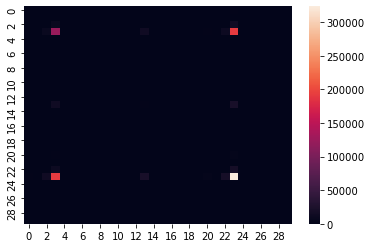

In [9]:
#### Computing covariance matrix, comparing unnormalized and normalized data
#### Here's the covariance of the unnormalized data
from sklearn.covariance import empirical_covariance
sn.heatmap(empirical_covariance(X_cancer))

<AxesSubplot:>

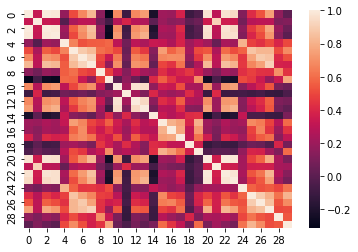

In [10]:
# and here's the covariance of the normalized data
sn.heatmap(empirical_covariance(X_cancer_normalized))

<AxesSubplot:>

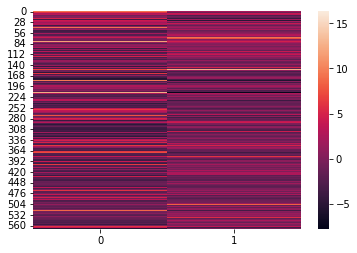

In [11]:
pca = PCA(n_components = 2).fit(X_cancer_normalized)
X_pca = pca.transform(X_cancer_normalized)
sn.heatmap(X_pca)

#### Plotting the PCA-transformed version of the breast cancer dataset

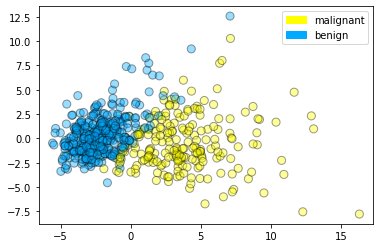

In [12]:
from adspy_shared_utilities import plot_labelled_scatter
plot_labelled_scatter(X_pca, y_cancer, ['malignant', 'benign'])

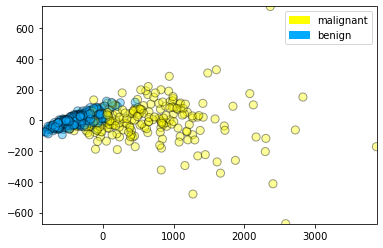

In [13]:
#### What happens if you forget to normalize the input to PCA?

pca_unnormalized = PCA(n_components = 2).fit(X_cancer)
X_pca_unnormalized = pca_unnormalized.transform(X_cancer)
plot_labelled_scatter(X_pca_unnormalized, y_cancer, ['malignant', 'benign'])

#### Plotting the magnitude of each feature value for the first two principal components

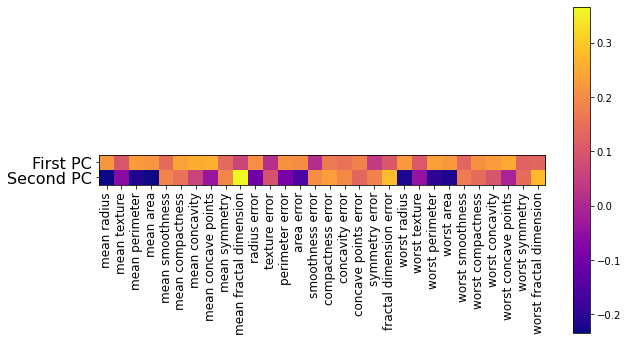

In [14]:
def plot_cancer_pca(pca, top_k = 2):
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.imshow(pca.components_[0:top_k], interpolation = 'none', cmap = 'plasma')
    feature_names=list(cancer.feature_names)
    plt.xticks(np.arange(-0., len(feature_names), 1) , feature_names, rotation = 90, fontsize=12)
    plt.yticks(np.arange(0., 2, 1), ['First PC', 'Second PC'], fontsize = 16)
    plt.colorbar()
    
plot_cancer_pca(pca)

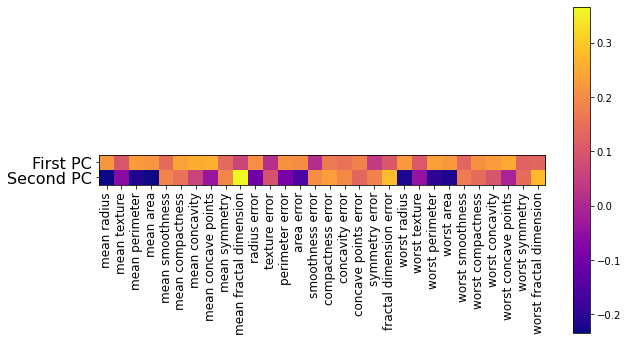

In [15]:
# Let's compare PCA with 3 components: regular and sparse

# First, regular PCA
pca = PCA(n_components = 3).fit(X_cancer_normalized)
plot_cancer_pca(pca)

66.67% of values are zero in Sparse PCA first component.


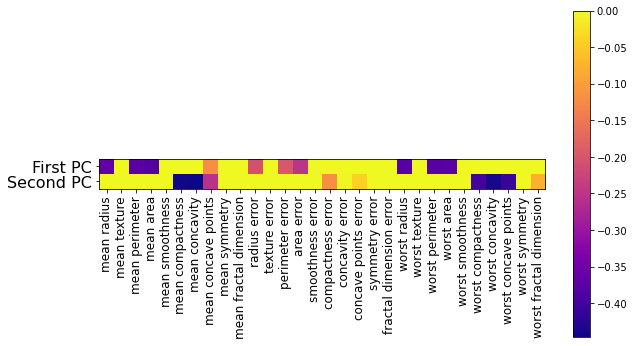

In [16]:
### Now let's try sparse PCA. The solution is sensitive to the choice of sparsity parameter alpha.

from sklearn.decomposition import SparsePCA
pca_sparse = SparsePCA(n_components=3, alpha = 15, random_state=0)
pca_sparse.fit(X_cancer_normalized)
X_transformed = pca_sparse.transform(X_cancer_normalized)

# most values in the components_ are zero (sparsity)
percentage = np.sum(pca_sparse.components_[0] == 0)/len(pca_sparse.components_[0])
print('{:2.2%} of values are zero in Sparse PCA first component.'.format(percentage))
plot_cancer_pca(pca_sparse)

### Reading a biplot

explained_variance_ratio: [0.44 0.19 0.09 0.07 0.05 0.04 0.02 0.02 0.01 0.01]
sum of explained variance ratios: 0.951568814335656
singular values: [86.93 56.91 40.04 33.57 30.63 26.21 19.6  16.47 15.4  14.13]
[13.3   5.7   2.82  1.98  1.65  1.21  0.68  0.48  0.42  0.35]
569


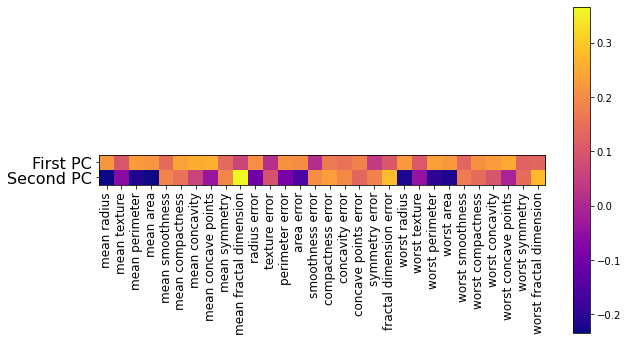

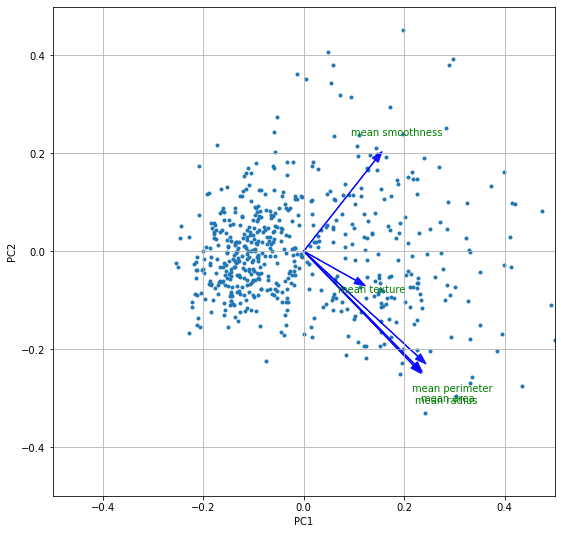

In [17]:
feature_subset_count = 5
pca = PCA(n_components = 10).fit(X_cancer_normalized)
X_pca = pca.transform(X_cancer_normalized)
plot_cancer_pca(pca)
feature_names=list(cancer.feature_names)

### Feel free to use this routine to plot your own biplots!
def biplot(score, coeff, maxdim, pcax, pcay, labels=None):
    zoom = 0.5
    pca1=pcax-1
    pca2=pcay-1
    xs = score[:,pca1]
    ys = score[:,pca2]
    n = min(coeff.shape[0], maxdim)
    width = 2.0 * zoom
    scalex = width/(xs.max()- xs.min())
    scaley = width/(ys.max()- ys.min())
    text_scale_factor = 1.3
        
    fig = plt.gcf()
    fig.set_size_inches(9, 9)
    
    plt.scatter(xs*scalex, ys*scaley, s=9)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],
                  color='b',alpha=0.9, head_width = 0.03 * zoom) 
        if labels is None:
            plt.text(coeff[i,pca1]* text_scale_factor, 
                     coeff[i,pca2] * text_scale_factor, 
                     "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(coeff[i,pca1]* text_scale_factor, 
                     coeff[i,pca2] * text_scale_factor, 
                     labels[i], color='g', ha='center', va='center')
    
    plt.xlim(-zoom,zoom)
    plt.ylim(-zoom,zoom)
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    plt.grid()

plt.figure()

feature_subset = slice(0, feature_subset_count, 1)

biplot(X_pca, np.transpose(pca.components_[0:2, feature_subset]), 
       feature_subset_count, 1, 2, labels=feature_names[feature_subset])

print("explained_variance_ratio:", pca.explained_variance_ratio_)
print("sum of explained variance ratios:", np.sum(pca.explained_variance_ratio_))
print("singular values:", pca.singular_values_)  

# The variances of the PCs are given by the squares of the singular values of X*, divided by n−1. 
# Since they are the eigenvalues of the (n-1)S matrix where S is the correlation matrix of X
print(np.power(pca.singular_values_, 2) / (X_cancer_normalized.shape[0] - 1))
print(X_cancer_normalized.shape[0])

### Scree plot to find optimal number of principal components

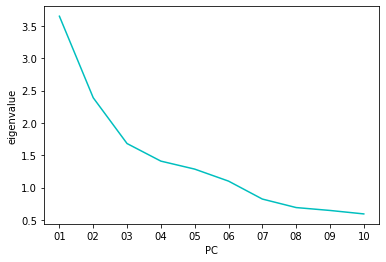

In [18]:
df = pd.DataFrame({'eigenvalue': np.sqrt(pca.explained_variance_),
                   'PC':['01','02','03','04','05','06','07','08','09','10']})
sn.lineplot(x = 'PC',y = "eigenvalue", data = df, color="c");

### Variance plot to find optimal number of principal components

0    0.442720
1    0.632432
2    0.726364
3    0.792385
4    0.847343
5    0.887588
6    0.910095
7    0.925983
8    0.939879
9    0.951569
Name: explained var ratio, dtype: float64

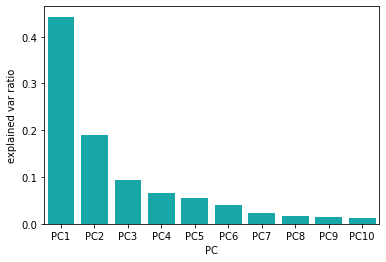

In [19]:
df = pd.DataFrame({'explained var ratio':pca.explained_variance_ratio_,
                   'PC':['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']})
sn.barplot(x = 'PC',y = "explained var ratio", data = df, color="c");
np.cumsum(df['explained var ratio'])

In [20]:
# Example using the 'pca' library in order to use their built-in biplot routine.
# Currently not supported in the Coursera environment. If you don't have this library locally, you can run: pip install pca

# from pca import pca

#model= pca(n_components = 10)
#results = model.fit_transform(X_cancer_normalized)

## Make biplot with the number of features
#fig, ax = model.biplot(n_feat=10, legend = False)#, labels=feature_names[feature_subset])
#plt.figure()

#### PCA on the fruit dataset (for comparison)

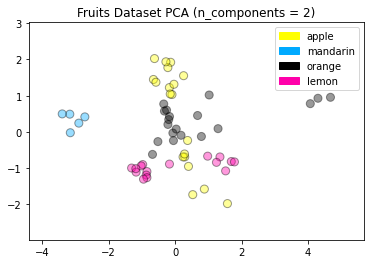

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# each feature should be centered (zero mean) and with unit variance
X_normalized = StandardScaler().fit(X_fruits).transform(X_fruits)  

pca = PCA(n_components = 2).fit(X_normalized)
X_pca = pca.transform(X_normalized)

from adspy_shared_utilities import plot_labelled_scatter
plot_labelled_scatter(X_pca, y_fruits, ['apple','mandarin','orange','lemon'], "Fruits Dataset PCA (n_components = 2)")

### Kernel PCA example

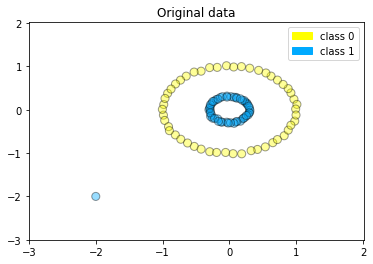

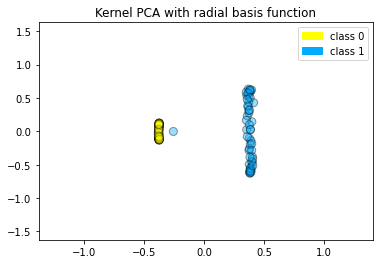

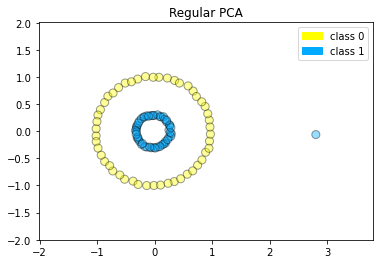

In [22]:
import numpy as np
import matplotlib.pyplot as plt

from adspy_shared_utilities import plot_labelled_scatter

from sklearn.datasets import make_circles
from sklearn.decomposition import PCA, KernelPCA

np.random.seed(0)

X, y = make_circles(n_samples = 100, noise = 0.01, factor = 0.3)

X = np.row_stack((X, [-2.0, -2.0]))
y = np.append(y, 1)

# from the adspy_shared_utilities module
plot_labelled_scatter(X, y, ['class 0', 'class 1'], title = "Original data")

kpca = KernelPCA(kernel = "rbf", gamma = 5)
X_kpca = kpca.fit_transform(X)

plot_labelled_scatter(X_kpca, y, ['class 0', 'class 1'], 
                      title = "Kernel PCA with radial basis function")

pca = PCA()
X_pca = pca.fit_transform(X)

plot_labelled_scatter(X_pca, y, ['class 0', 'class 1'], title = "Regular PCA")


## Manifold learning methods

### Multidimensional scaling (MDS) on the fruit dataset

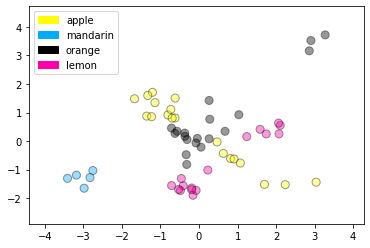

In [23]:
from adspy_shared_utilities import plot_labelled_scatter
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS

# each feature should be centered (zero mean) and with unit variance
X_fruits_normalized = StandardScaler().fit(X_fruits).transform(X_fruits)  

mds = MDS(n_components = 2, metric = True)
X_fruits_mds = mds.fit_transform(X_fruits_normalized)

plot_labelled_scatter(X_fruits_mds, y_fruits, ['apple', 'mandarin', 'orange', 'lemon'])

#### Multidimensional scaling (MDS) on the breast cancer dataset

(This example is included here so you can compare it to the results from PCA.)

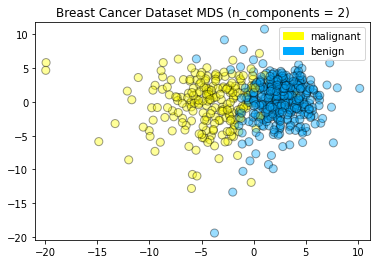

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)

# each feature should be centered (zero mean) and with unit variance
X_normalized = StandardScaler().fit(X_cancer).transform(X_cancer)  

mds = MDS(n_components = 2)

X_mds = mds.fit_transform(X_normalized)

from adspy_shared_utilities import plot_labelled_scatter
plot_labelled_scatter(X_mds, y_cancer, ['malignant', 'benign'], title = "Breast Cancer Dataset MDS (n_components = 2)")


#### t-SNE on the fruit dataset

(This example from the lecture video is included so that you can see how some dimensionality reduction methods may be less successful on some datasets. Here, it doesn't work as well at finding structure in the small fruits dataset, compared to other methods like MDS.)

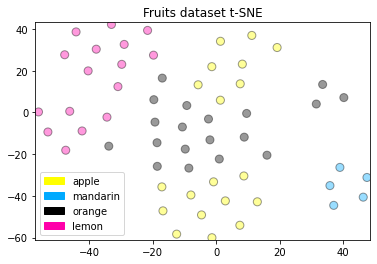

In [25]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state = 0)

X_tsne = tsne.fit_transform(X_fruits_normalized)

plot_labelled_scatter(X_tsne, y_fruits, 
    ['apple', 'mandarin', 'orange', 'lemon'], title = "Fruits dataset t-SNE")


#### t-SNE on the breast cancer dataset

Although not shown in the lecture video, this example is included for comparison, showing the results of running t-SNE on the breast cancer dataset.  See the reading "How to Use t-SNE effectively" for further details on how the visualizations from t-SNE are affected by specific parameter settings.

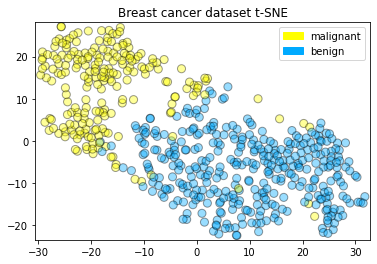

In [26]:
tsne = TSNE(random_state = 0)

X_tsne = tsne.fit_transform(X_normalized)

plot_labelled_scatter(X_tsne, y_cancer, 
    ['malignant', 'benign'], title = "Breast cancer dataset t-SNE")

## Density Estimation

### Histograms

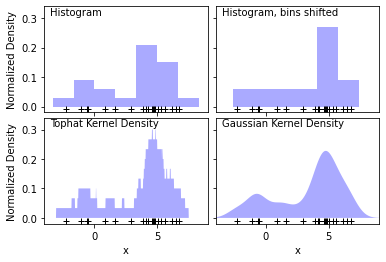

In [27]:
density_param = {'density': True}

# Plot the progression of histograms to kernels
np.random.seed(1)
N = 20
X = np.concatenate((np.random.normal(0, 1, int(0.3 * N)),
                    np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]
bins = np.linspace(-5, 10, 10)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# histogram 1
ax[0, 0].hist(X[:, 0], bins=bins, fc='#AAAAFF', **density_param)
ax[0, 0].text(-3.5, 0.31, "Histogram")

# histogram 2
ax[0, 1].hist(X[:, 0], bins=bins + 0.75, fc='#AAAAFF', **density_param)
ax[0, 1].text(-3.5, 0.31, "Histogram, bins shifted")

# tophat KDE
kde = KernelDensity(kernel='tophat', bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 0].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[1, 0].text(-3.5, 0.31, "Tophat Kernel Density")

# Gaussian KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 1].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[1, 1].text(-3.5, 0.31, "Gaussian Kernel Density")

for axi in ax.ravel():
    axi.plot(X[:, 0], np.full(X.shape[0], -0.01), '+k')
    axi.set_xlim(-4, 9)
    axi.set_ylim(-0.02, 0.34)

for axi in ax[:, 0]:
    axi.set_ylabel('Normalized Density')

for axi in ax[1, :]:
    axi.set_xlabel('x')

def format_func(x, loc):
    if x == 0:
        return '0'
    elif x == 1:
        return 'h'
    elif x == -1:
        return '-h'
    else:
        return '%ih' % x

### Kernel density estimation

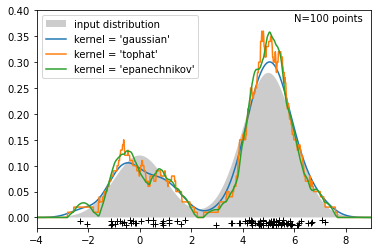

In [28]:
## Note: modify this original code

#----------------------------------------------------------------------
# Plot a 1D density example
N = 100
np.random.seed(1)
X = np.concatenate((np.random.normal(0, 1, int(0.3 * N)),
                    np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]

X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

true_dens = (0.3 * norm(0, 1).pdf(X_plot[:, 0])
             + 0.7 * norm(5, 1).pdf(X_plot[:, 0]))

fig, ax = plt.subplots()
ax.fill(X_plot[:, 0], true_dens, fc='black', alpha=0.2,
        label='input distribution')

for kernel in ['gaussian', 'tophat', 'epanechnikov']:
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(X_plot[:, 0], np.exp(log_dens), '-',
            label="kernel = '{0}'".format(kernel))

ax.text(6, 0.38, "N={0} points".format(N))

ax.legend(loc='upper left')
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)
plt.show()

In [29]:
#### Get probabilities under the estimated density, using score_samples on a toy dataset
X_toy = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
outliers = np.array([[-5, -6], [7, 8]])

kde = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(X_toy)

# note that we call np.exp() since score_samples returns LOG probabilities
print("Probabilities of training points:", np.exp(kde.score_samples(X_toy)))
print("Probabilities of new (outlier) points:", np.exp(kde.score_samples(outliers)))

# sample 3 new points from this density
print("Sample 3 random points from this density:\n", kde.sample(3))

Probabilities of training points: [0.3  0.3  0.29 0.3  0.3  0.29]
Probabilities of new (outlier) points: [1.64e-049 1.02e-126]
Sample 3 random points from this density:
 [[-1.18 -0.7 ]
 [ 1.05  1.28]
 [-2.84 -2.18]]


### Finding the optimal kernel bandwidth

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

## This uses the X random 1-d data computed in a previous cell.

## Note that the score (being optimized) by default is the total log-likehihood of the data
## which is what the KernelDensity score(...) methods returns.

bandwidths = 10 ** np.linspace(-1, 1, 20)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(X);
print("Optimal bandwidth:", grid.best_params_)
print("Data log-likelihood:", grid.best_score_)

Optimal bandwidth: {'bandwidth': 0.42813323987193935}
Data log-likelihood: -1.9649814109010284


### Gaussian mixture model example

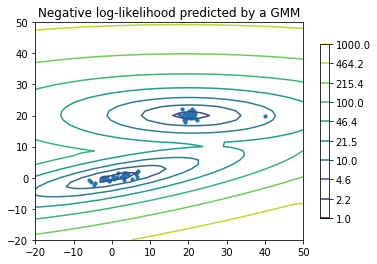

In [31]:
# Adapted from https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

n_samples = 30

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

# add an outlier point
shifted_gaussian = np.vstack([shifted_gaussian, [40, 20]])

# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-20., 50.)
y = np.linspace(-20., 50.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)  
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train[:, 0], X_train[:, 1], 10)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()